In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

## Minimum Variance Portfolio Backtest.

In [2]:
from qamsi.config.trading_config import TradingConfig
from qamsi.strategies.estimated.min_var import MinVariance
from qamsi.cov_estimators.cov_estimators import CovEstimators
from run import Dataset, initialize

In [3]:
REBAL_FREQ = "ME"
DATASET = Dataset.TOPN_US
TOP_N = 30
ESTIMATION_WINDOW = 365

ESTIMATOR = CovEstimators.RF_XIU.value(shrinkage_type="linear")

In [4]:
trading_config = TradingConfig(
    total_exposure=1,
    max_exposure=None,
    min_exposure=None,
    trading_lag_days=1,
)

preprocessor, runner = initialize(
    dataset=DATASET,
    trading_config=trading_config,
    topn=TOP_N,
    rebal_freq=REBAL_FREQ,
)

Backtest on 2000-12-29 00:00:00 to 2024-07-31 00:00:00
Num Train Iterations: 283
Num OOS Daily Points: 5932


In [5]:
strategy = MinVariance(
    cov_estimator=ESTIMATOR,
    trading_config=trading_config,
    window_size=ESTIMATION_WINDOW,
)

strategy_name = ESTIMATOR.__class__.__name__

result = runner(
    feature_processor=preprocessor,
    strategy=strategy,
    hedger=None,
)
result

Computing Weights: 100%|██████████| 283/283 [18:15<00:00,  3.87s/it]


StrategyStatistics:
* final_nav = 12.097414
* geom_avg_total_r = 0.140106
* geom_avg_xs_r = 0.120809
* std_xs_r = 0.147703
* min_xs_r = -0.080164
* max_xs_r = 0.102405
* skew = 0.079469
* kurtosis = 13.817966
* max_dd = -0.263537
* sharpe = 0.817923
* alpha_buy_hold = 0.062535
* tracking_error_buy_hold = 0.146366
* ir_buy_hold = 0.427250
* factor_loadings = {'low_risk': 0.5314023000277653, 'momentum': -0.055901508656807306, 'quality': 0.13263110980942217, 'size': 0.05590776734757955, 'value': -0.20639353551888961, 'spx': 0.7249617269941622}
* alpha_benchmark = 0.059342
* alpha_benchmark_pvalue = 0.004156
* tracking_error_benchmark = 0.086699
* ir_benchmark = 0.684457
* ttest_pval = 0.230486
* levene_pval = 0.000000
* timing_ability_coef = -0.028853
* timing_ability_pval = 0.072494

In [6]:
result.std_xs_r, result.sharpe

(0.14770275016815468, 0.8179230868123059)

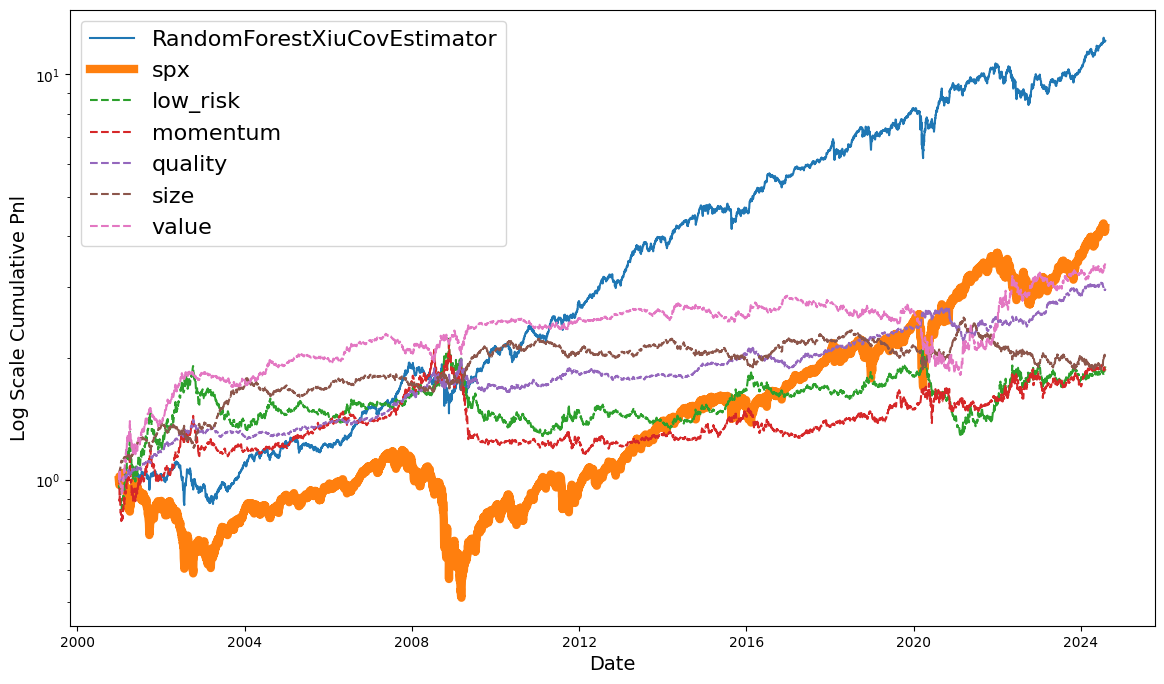

In [7]:
runner.plot_cumulative(
    strategy_name=strategy_name,
    include_factors=True,
)

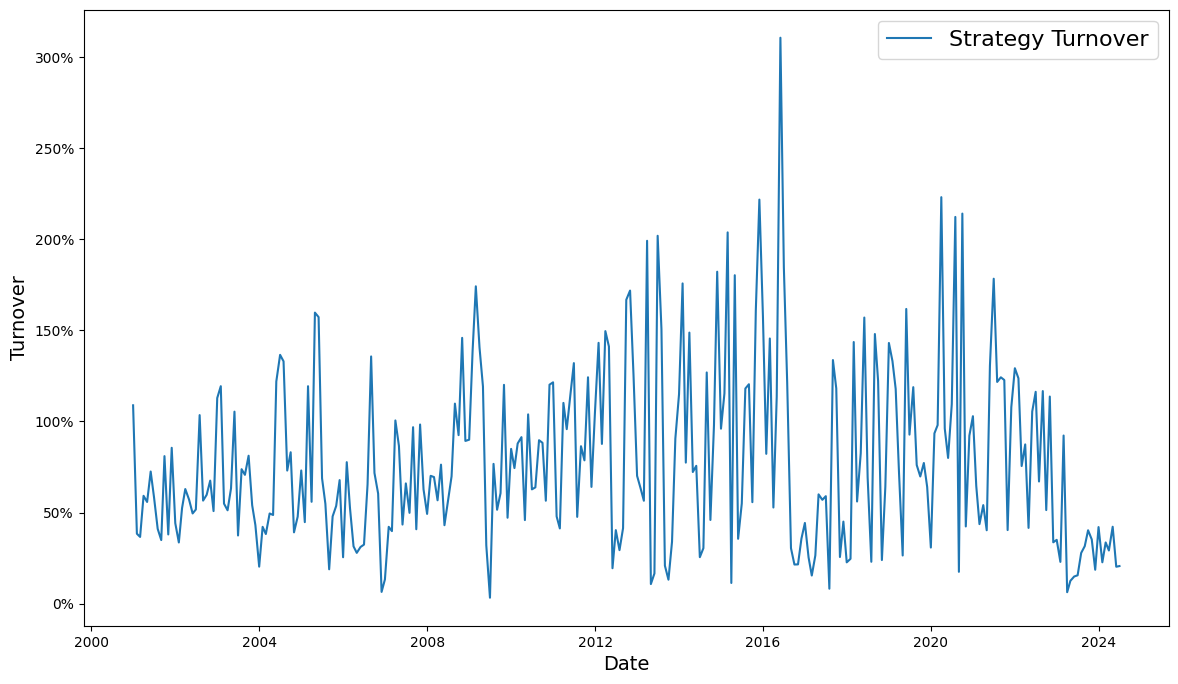

In [8]:
runner.plot_turnover()

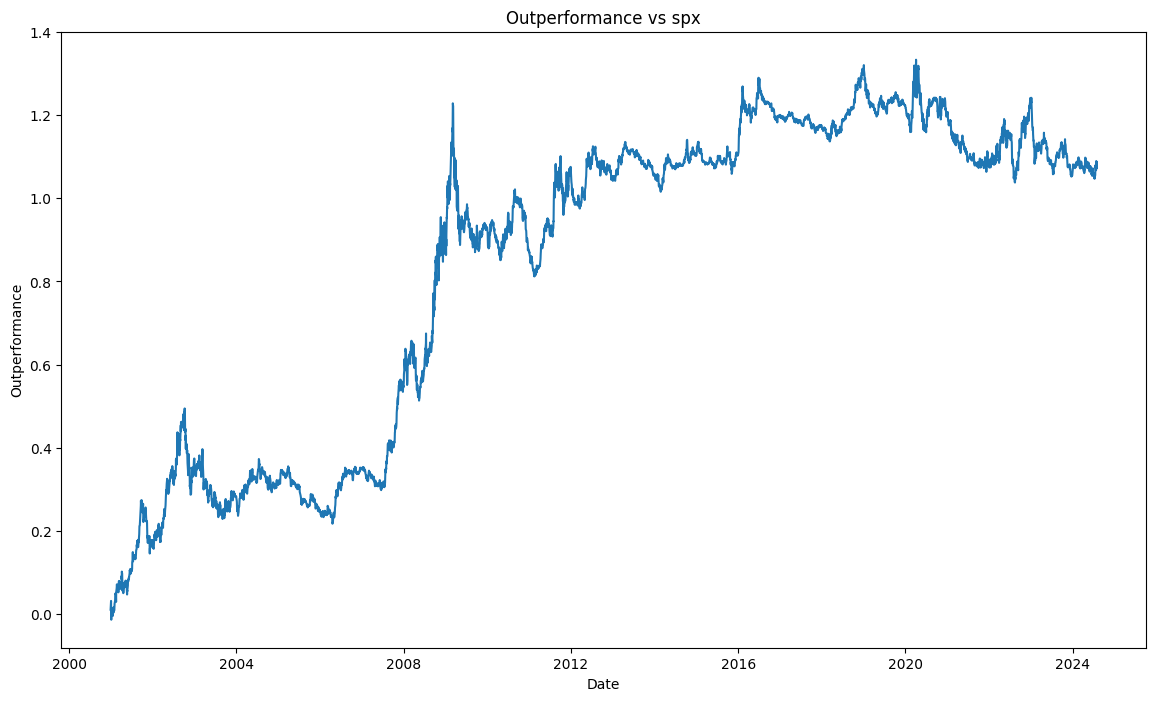

In [9]:
runner.plot_outperformance(mkt_only=True)

In [10]:
runner.save(DATASET.name + strategy_name + f"_rebal{REBAL_FREQ}")

AttributeError: 'RandomForestXiuCovEstimator' object has no attribute 'name'

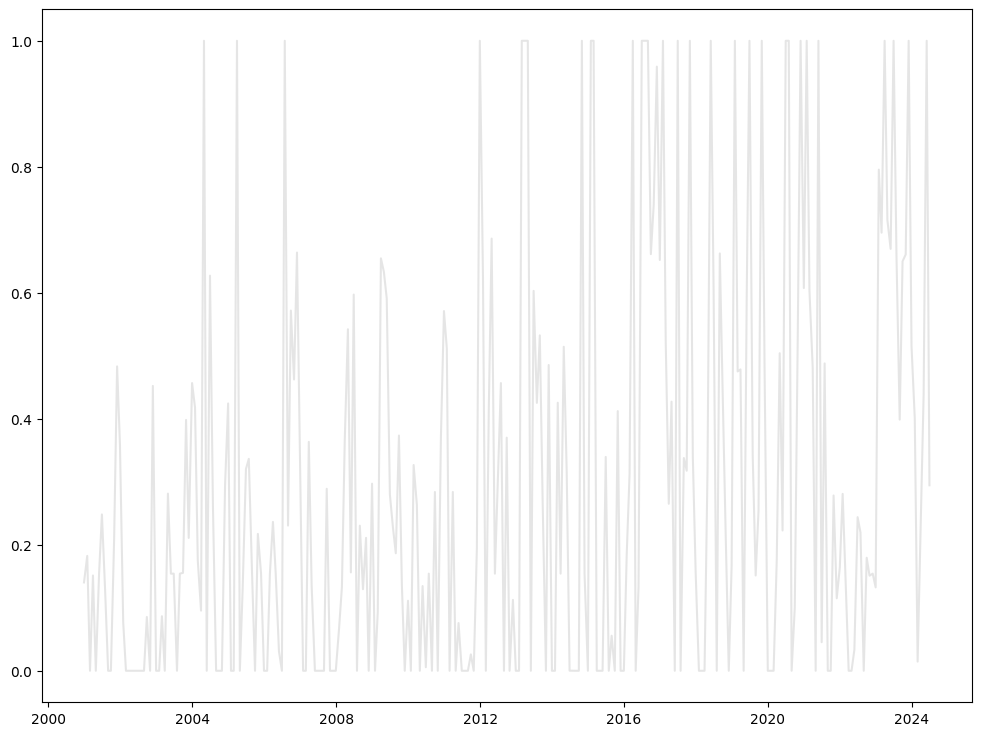

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))

pred = ESTIMATOR.predictions

targets = runner.targets.loc[pred.index, "target"]
# ma = runner.features.loc[pred.index, "target_rolling_mean"].shift(1)

plt.plot(
    targets.index,
    targets.to_numpy(),
    label="True",
    color="grey",
    alpha=0.2,
)
plt.plot(pred.index, pred.to_numpy(), label=f"{ESTIMATOR.name}")
# plt.plot(ma.index, ma.to_numpy(), label="MA")

plt.legend()
plt.show()

In [12]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(targets, pred)

0.05254141973288693

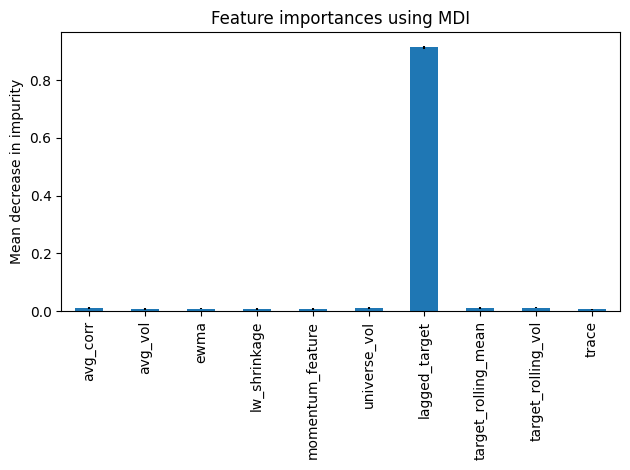

In [13]:
import numpy as np
import pandas as pd

feature_names = runner.features.columns
importances = ESTIMATOR.rf.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
std = np.std([tree.feature_importances_ for tree in ESTIMATOR.rf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

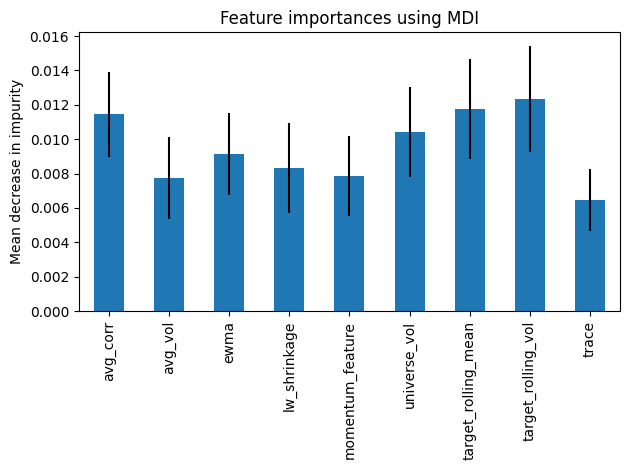

In [14]:
fig, ax = plt.subplots()
forest_importances.drop("lagged_target").plot.bar(
    yerr=np.concatenate([std[:6], std[7:]]), ax=ax
)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [15]:
std

array([0.00246226, 0.00237807, 0.00237225, 0.00261894, 0.00231055,
       0.00260294, 0.00550962, 0.00291611, 0.00309808, 0.00178709])

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

(
    (targets.to_numpy() - pred.to_numpy()).mean(),
    mean_absolute_error(targets, pred),
    mean_squared_error(targets, pred),
)

(-0.006736793331816824, 0.05254141973288693, 0.009497820458377451)

In [18]:
rf = ESTIMATOR.rf
rf

,n_estimators,30
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


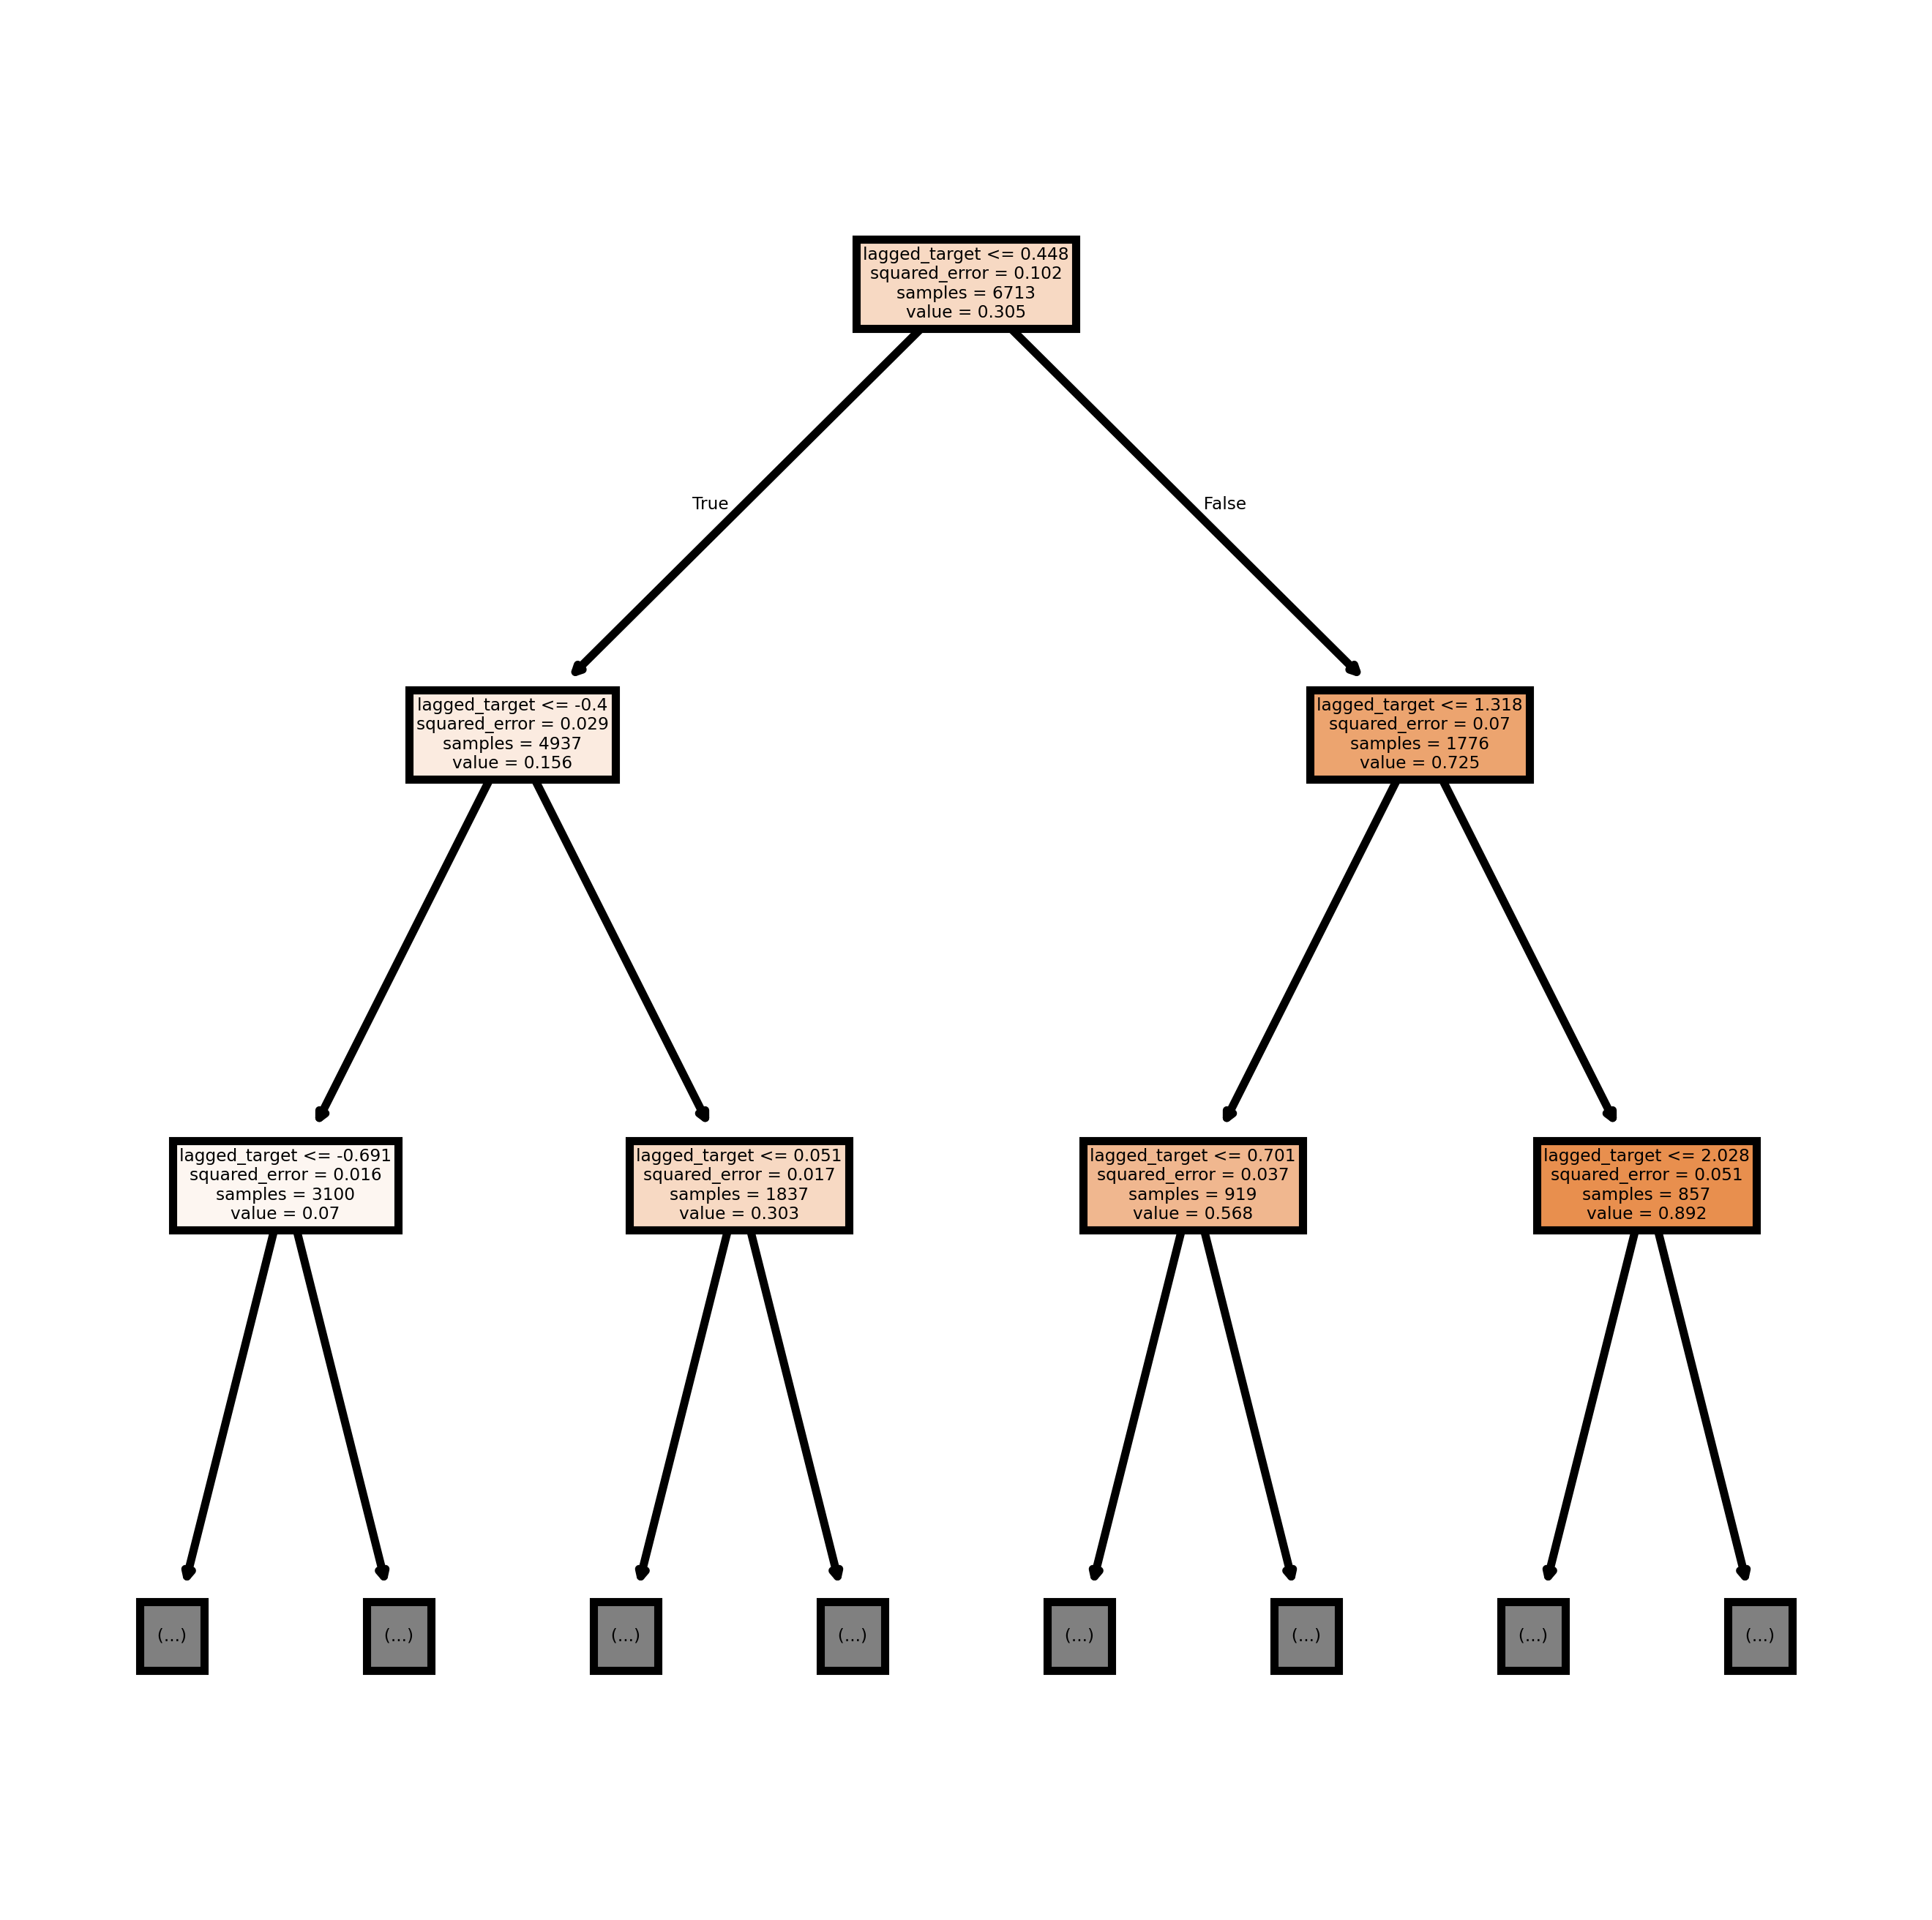

In [21]:
from sklearn import tree

fn = feature_names
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=800)
tree.plot_tree(
    rf.estimators_[0],
    feature_names=fn,
    filled=True,
    max_depth=2,
);
# fig.savefig('rf_individualtree.png')